# Projeto 1: Regressão Linear

O projeto consiste em explorar modelos de regressão linear para prever o volume de tráfego de uma rodovia [Interstate 94](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) a partir de 8 _features_ :

- Feriado
- Temperatura (em Kelvin)
- Chuva (em 1h)
- Neve (em 1h)
- Nuvens (porcentagem)
- Clima (curto)
- Clima (longo)
- Data/Hora

O valor alvo é o volume de tráfego, que também está disponível no _dataset_.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from csv import reader
from time import time
from datetime import date as date_check 
from holidays import UnitedStates
from random import randint, shuffle, sample
from sklearn import linear_model
from sklearn.metrics import explained_variance_score, median_absolute_error, mean_squared_error

Primeiro, podemos __visualizar__ os dados por meio da biblioteca de visualização abaixo:

In [2]:
def stats_hist(data):
    ''' Transforms data to pandas dataframe and gets stats/histogram
    '''
    pd.DataFrame(data)
    print(data.describe())
    hist=data.hist(bins=50)
    plt.show()

def date_split(string):
    ''' Read date-time in "yyyy-mm-dd hh:mm:ss" and cast to int.

        Parameters:
            string (string): string containing the mentioned format.

        Returns:
            (dictionary): contains date-time info indexed by initials.
    '''
    date = re.split("-|:| ", string)
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    hour = int(date[3])

    return {"h":hour, "d":day, "m":month, "y":year}

# Plots a relation between the average daily traffic per hour
def avg_traffic_hour_daily(data):
    # OBS: there are duplicated time stamps to separate more than one
    # enviromental condition (p.e. if its foggy and cloudy there will be duplicates)
    curr_day = 0
    traffic_hour = []
    for x in data[1:] :
        hour, day, _, _ = date_split(x[7]).values()
        if (day != curr_day):
            curr_day = day
            traffic_hour.append(np.array([0]*24))
        traffic_hour[-1][hour] = x[-1]

    avg = sum(traffic_hour)/len(traffic_hour)
    plt.plot(range(0,24), avg)
    plt.xticks(range(0,24))
    plt.title("Análise do tráfego por hora")
    plt.xlabel("Horas do dia (00h-24h)")
    plt.ylabel("Média diária de tráfego")
    print('Plotting')
    plt.grid()
    plt.show()

    return

def avg_traffic_day_weekly(data):
    # NEEDS HEADER
    # OBS: there are duplicated time stamps to separate more than one
    # enviromental condition (p.e. if its foggy and cloudy there will be duplicates)
    traffic_day = []
    data = pd.DataFrame(data)
    data['date_time'] = pd.to_datetime(data['date_time'])
    data['weekday'] = data['date_time'].dt.weekday
    
    for i in range(0,7):
        dt = data.loc[data['date_time'].dt.weekday == i]
        traffic_day.append(dt['traffic_volume'].mean())
        
    plt.plot(range(0,7), traffic_day)
    plt.xticks(range(0,7))
    plt.title("Análise do tráfego por dia")
    plt.xlabel("Dias da semana (Segunda a Domingo)")
    plt.ylabel("Média semanal de tráfego")
    print('Plotting')
    plt.grid()
    plt.show()

    return

# Plot a realtion between weather descriptions and the average daily traffic per hour
def avg_traffic_per_weather(data):

    desc_main = {y:[0,0] for y in list(set([x[5] for x in data[1:]]))}
    desc = {y:[0,0] for y in list(set([x[6] for x in data[1:]]))}
    
    for x in data[1:]:
        desc_main[x[5]][0] += 1
        desc_main[x[5]][1] += int(x[-1])
        desc[x[6]][0] += 1
        desc[x[6]][1] += int(x[-1])

    counts = [x[0] if x[0]>0 else 1 for x in desc_main.values()]
    sums = [x[1] for x in desc_main.values()]
    desc_main_avg = np.array(sums)/np.array(counts)

    counts = [x[0] if x[0]>0 else 1  for x in desc.values()]
    sums = [x[1] for x in desc.values()]
    desc_avg = np.array(sums)/np.array(counts)
    
    a = plt.figure(1)
    plt.plot(list(desc.keys()), desc_avg)
    plt.xticks(list(desc.keys()), rotation='vertical')
    plt.margins(0)
    plt.subplots_adjust(bottom=0.5)
    plt.title("Análise do tráfego por descrição específica do clima")
    plt.xlabel("Descrições específicas do clima")
    plt.ylabel("Média diária de tráfego")
    plt.grid()
    
    b = plt.figure(2)
    plt.plot(list(desc_main.keys()), desc_main_avg)
    plt.title("Análise do tráfego por descrição geral do clima")
    plt.xlabel("Descrições gerais do clima")
    plt.ylabel("Média diária de tráfego")
    
    plt.grid()
    plt.show()
    input()
    
    return


Plotting


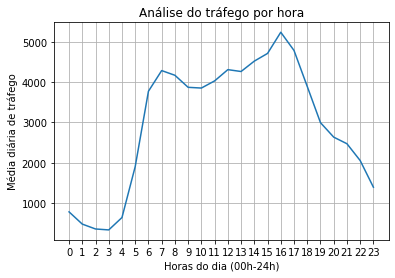

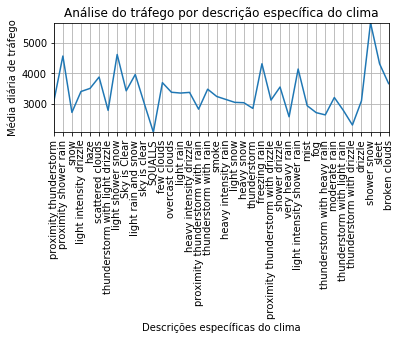

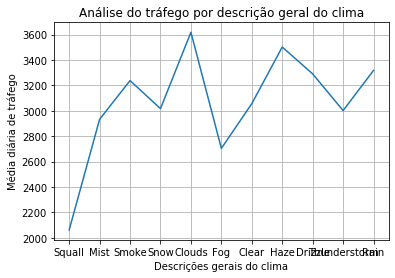


Plotting


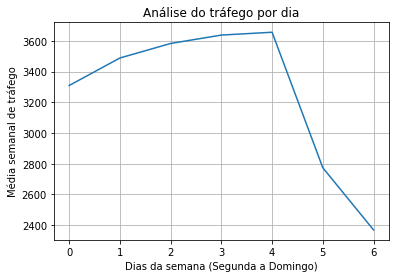

In [3]:
dataset = open('Metro_Interstate_Traffic_Volume.csv')
data = list(map(lambda x: x.split(","), dataset.readlines()))
avg_traffic_hour_daily(data)
avg_traffic_per_weather(data)
dataset.close()

data=pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
avg_traffic_day_weekly(data)


Pode-se notar relações entre algumas _features_ e o valor objetivo. As relações mais clara e fáceis de explicar são entre horários de pico durante o dia e maior tráfego durante a semana. 

Depois, devemos __separar__ os conjuntos de treino e validação (e teste).

In [4]:
VALID_FILE = 'validate.csv'
TEST_FILE  = 'test.csv'
TRAIN_FILE = 'training.csv'

def split_sets(filename, test_sz=0.1, valid_sz=0.1):
    '''
        Splits dataset between TRAINING, VALIDATION and TEST sets.
    '''
    
    # Reading csv into numpy array
    f = open(filename, 'r')
    data = list(reader(f, delimiter=','))
    f.close()
    
    # Header
    data = np.array(data)
    header = data[0]
    data = data[1:]
    
    # Amount of examples (+ first row)
    amount = np.size(data, 0)
    
    # Getting validation set from random positions and saving to CSV file
    valid_idx = np.array(sample(range(amount), int(np.floor(amount*valid_sz))))
    valid = np.vstack((header, data[valid_idx]))
    np.savetxt(VALID_FILE, valid, delimiter=',', fmt='%s')
    
    # Removing validation data from data and getting new number of rows
    data = np.delete(data, valid_idx, 0)
    new_amount = np.size(data, 0)
    
    # Getting test set from random positions and saving to CSV file
    test_idx = np.array(sample(range(new_amount), int(np.floor(amount*test_sz))))
    if (len(test_idx) > 0):
        test = np.vstack((header, data[test_idx]))
        np.savetxt(TEST_FILE, test, delimiter=',', fmt='%s')
    
        # Removing test data and saving training set to CSV file
        data = np.delete(data, test_idx, 0)
        
    data = np.vstack((header, data))
    np.savetxt(TRAIN_FILE, data, delimiter=',', fmt='%s')

In [5]:
split_sets('Metro_Interstate_Traffic_Volume.csv', 0, 0.2)

Feito isso, temos que realizar uma __engenharia de features__ , que consiste em criar _features_ novas a partir das que temos, e deixá-las em um estado útil (numérico). Dois conjuntos de _features_ foram feitos.

O primeiro conjunto verifica os feriados pela biblioteca "holidays", e expande via One Hot Encoding quase tudo: descrição detalhada (certos tipos) e resumida de clima, dias da semana, horas do dia. Ambos conjuntos eliminam valores com medições de temperatura em zero absoluto, valores absurdos de chuva e valores duplicados, considerando apenas o primeiro.

In [6]:
def process_input_first(data):
    ''' Remove and re-format input data.

        Parameters:
            data (array list): csv table with the dataset header and content.
            
        Returns:
            data_frame (array list):  processed input data.
    '''

    # Features list
    new_head = ['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'thunderstorm with light rain', 'shower snow', 'thunderstorm with heavy rain', 'drizzle', 'light intensity shower rain', 'proximity shower rain', 'thunderstorm', 'heavy snow', 'proximity thunderstorm with rain', 'thunderstorm with rain', 'proximity thunderstorm', 'squalls', 'few clouds', 'light rain and snow', 'smoke', 'scattered clouds', 'thunderstorm with light drizzle', 'sky is clear', 'very heavy rain', 'light intensity drizzle', 'broken clouds', 'snow', 'heavy intensity rain', 'sleet', 'thunderstorm with drizzle', 'heavy intensity drizzle', 'light snow', 'light shower snow', 'moderate rain', 'haze', 'shower drizzle', 'proximity thunderstorm with drizzle', 'fog', 'mist', 'overcast clouds', 'freezing rain', 'light rain', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', 'mon', 'tue', 'wed', 'thu', 'fry', 'sat', 'sun', 'traffic_volume']
    data_frame = [new_head]
    holidays = UnitedStates(state='MN')

    # Alter and remove data
    for (i,d) in enumerate(data[1:], start=1):
        # Cast weather description to lower case
        data[i][6] = d[6].lower()

        # Propagate holidays and cast them to binary
        if d[0] == 'None' : 
            # In case theres no holiday
            data[i][0] = 0.0 
        elif d[-2].split()[0] in holidays:
            # In case its a known minnesota holyday date
            data[i][0] = 1.0 
        else:
            # Unknown holidays are discarded for simplicity
            data[i][0] = 0.0

    # # Discrete variables lists
    weekdays = {0:"mon", 1:"tue", 2:"wed", 3:"thu", 4:"fry", 5:"sat", 6:"sun"}
    # desc_list = list(set([x[6] for x in data[1:]])) # Get unique values
    # hour_list = list(map(str,range(0,24)))
    
    # # Defining the new header and frame for processed data
    # new_head = data[0][0:5] + desc_list + hour_list + list(weekdays.values()) + [data[0][-1][0:-1]]

    # Indexes to be casted
    cast_float = [1,2,3,4,8]

    for i in range(1,len(data)):
        # Ignore data with 0 kelvin
        if float(data[i][1]) == 0 : continue
        # Ignore duplicate hours (due to multiple weather description)
        if data[i-1][-2] == data[i][-2] : continue
        # Ignore ridiculous ammounts of rain
        if float(data[i][2]) > 300 : continue
        # Cast numeric values read as string to float
        for j in cast_float : 
            data[i][j] = float(data[i][j]) 

        # Add row to dataframe
        data_frame.append([0.0]*len(new_head)) 
        
        # split and cast date
        hour, day, month, year = date_split(data[i][-2]).values()

        # Set discrete weekday variable
        day_name = weekdays[date_check(year,month,day).weekday()]
        data_frame[-1][new_head.index(day_name)] = 1.0

        # Set discrete hour variable
        data_frame[-1][new_head.index(str(hour))] = 1.0

        # Set discrete weather description variables
        j = i
        while j < len(data) and data[j][-2] == data[i][-2] :
            data_frame[-1][new_head.index(data[j][6])] = 1.0 
            j += 1

        # Set quantitative data
        data_frame[-1][-1] = data[i][-1]
        data_frame[-1][:5] = data[i][:5]     

    return data_frame

def prepare_dataset_first(set_name):
    ''' Reads and prepares a dataset for regression.
    
        Returns:
            X (array list): coeficients matrix with label.
            Y (array list): results matrix with label.
    '''

    datafile = open(set_name)
    data = list(map(lambda x : x.split(","), datafile.readlines()))

    data = process_input_first(data)
    
    # Separate processed data in coeficients and results
    X = data[1:] # Remove header
    Y = [[x.pop()] for x in X]

    # Returns processed input and indexes to be normalized
    return X, Y, [1,2,3,4]

O segundo conjunto de _features_ foi feito com a intenção de reduzir a redundância, diminuindo o tamanho da matriz final. Para isso foram cogitadas diversas _features_ novas baseadas na visualização dos dados feita acima.
Dias da semana agora foram divididos entre "weekday" ou não, e as informações da hora, do dia, mês e ano de cada exemplo também foram incluídas. Porém, foram eliminadas as _features_ que indicam feriados e cada dia da semana separadamente.
Foram cogitadas _features_ representando horários de pico, comercial e noturno, porém foi verificado que tornavam o modelo pior que apenas enumerar as horas.
Nesse modelo, apenas as descrições resumidas do clima foram utilizadas, pois as descrições detalhadas eram muito específicas de poucos dias.

In [7]:
def prepare_dataset_last(set_path):
    
    # Reading file to dataframe
    df = pd.read_csv(set_path)
    
    # Cleaning
    df = process_input_last(df)
    
    Y = df['traffic_volume'].values
    Y = Y.reshape(len(Y),1)
    
    X = df.drop(axis=1, labels='traffic_volume')
    
    feat_norm = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour', 'day', 'month', 'year']
    feat_idx = [X.columns.get_loc(c) for c in feat_norm]
    
    return X.values,Y,feat_idx

def process_input_last(data):
    ''' Remove and re-format input data.
        Receives pandas dataframe with all data.
        Returns processed data.
    '''
    # Removes 0 kelvin values, ridiculous amounts of rain and duplicate measurements for same time.
    data.drop(data[(data['temp'] == 0) | (data['rain_1h'] > 300)].index, inplace = True)
    data.drop_duplicates('date_time', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    # Get day, hour, month, year
    data['date_time'] = pd.to_datetime(data['date_time'])
    data['hour'] = data['date_time'].dt.hour
    data['day'] = data['date_time'].dt.day
    data['month'] = data['date_time'].dt.month
    data['year'] = data['date_time'].dt.year

    # Get holidays, and propagate them
    #data['holiday'] = np.where(data['holiday'] == 'None', 0, 1)
    #hol, day = data['holiday'].to_numpy(), data['day'].to_numpy()
    #for i in range(len(hol)-1):
    #    hol[i+1] = 1 if hol[i] == 1 and day[i] == day[i+1] else 0
    #data['holiday'] = pd.DataFrame(hol)
    
    # Get weekdays
    data['weekday'] = data['date_time'].dt.weekday    
    data['weekday'] = np.where((data['weekday']) == 5 | (data['weekday'] == 6), 0, 1)
    
    data.drop(labels=['date_time','holiday'], axis=1, inplace=True)
    
    # Get peak, commercial and night times
    #peak = list(range(15,18))
    #comm = list(range(6, 19))
    #night= list(range(0,5))
    #data['peak'] = np.where((data['hour'] >= peak[0]) & (data['hour'] <= peak[-1]), 1, 0)
    #data['commercial'] = np.where((data['hour'] >= comm[0]) & (data['hour'] <= comm[-1]), 1, 0)
    #data['night'] = np.where((data['hour'] >= night[0]) & (data['hour'] <= night[-1]), 1, 0)
    
    # Get every hour
    hours = list(range(0,24))
    for i in hours:
        data[i] = np.where(data['hour'] == i, 1, 0)
    
    # Weather variables
    weather_main = ['Clear', 'Clouds', 'Rain', 'Drizzle', 'Fog', 'Mist', 'Haze', 'Thunderstorm', 'Snow', 'Smoke', 'Squall']
    
    for i in weather_main:
        data[i] = np.where(data['weather_main'] == i, 1, 0)
    
    data.drop(labels=['weather_description', 'weather_main'], axis=1, inplace=True)

    return data    


Com as _features_ do conjunto, uma parte importante do processo é a normalização dos dados, podendo ser feita como:

- _Min-Max Normalization_
- _Standardization_
- _Mean Normalization_

O conjunto de _features_ inclui também uma lista de quais deverão sofrer normalização.

In [8]:
def normalize_data(data, choice=1, features=[1,2,3,4]):
    ''' Returns the normalized dataset.
    
        Parameters:
            data (array list): csv table with the dataset (without the header).
            choice (int): integer indicating the transformation to be used.
            features (int list): Indexes of the features to be normalized.

        Returns:
            data (array list):  transformed data (original data is lost).
    '''

    # Data to be colected
    ranges = []
    means = []
    maxs = []
    mins = []
    stds = []

    # Gathering necessary data
    features_list = [[d[f] for d in data] for f in features]
    for fl in features_list:
        means.append(np.mean(fl))
        maxs.append(max(fl))
        mins.append(min(fl))
        stds.append(np.std(fl))
        ranges.append(maxs[-1]-mins[-1])

    #### Transforming the dataset ####

    if choice == 1:
        # Min-max normalization
        for entry in data:
            for (i,f) in enumerate(features):
                entry[f] = (entry[f] - mins[i])/ranges[i]  
    elif choice == 2:
        # Standardization
        for entry in data:
            for (i,f) in enumerate(features):
                entry[f] = (entry[f] - means[i])/stds[i]
    elif choice == 3:
        # Mean normalization
        for entry in data:
            for (i,f) in enumerate(features):
                entry[f] = (entry[f] - means[i])/ranges[i] 
                
    return data

def numpy_and_bias(X, Y, T_set=(-10,10)):
    '''
        Transforms lists for X and Y into numpy arrays.
        Adds bias to feature matrix (X)
    '''
    
    X = np.array(X)
    Y = np.array(Y)
    X = np.insert(X, 0, 1, axis=1)
    T = np.array([[randint(-T_set[0],T_set[1])] for x in range(X.shape[1])])
    X = X.astype(float)
    Y = Y.astype(float)
    
    return (X,T,Y)


A partir deste ponto, X se refere à matriz de _features_ , e Y se refere aos valores alvo. Será utilizado _Min-Max Normalization_ .

In [9]:
# ### Getting Training Set ###
# Returns the data split between features and target.
X_1, Y_1, feat_list_1 = prepare_dataset_first("training.csv")
X_2, Y_2, feat_list_2 = prepare_dataset_last("training.csv")

# Normalize the features pointed by the received model
X_1 = normalize_data(X_1, choice=1, features=feat_list_1)
X_2 = normalize_data(X_2, choice=1, features=feat_list_2)

# Add bias and turn into numpy arrays (if not already)
# Initialize thetas.
X_1,T_1,Y_1 = numpy_and_bias(X_1,Y_1)
X_2,T_2,Y_2 = numpy_and_bias(X_2,Y_2)

# Validation set
# features to be normalized are the same
X_val_1, Y_val_1, _ = prepare_dataset_first("validate.csv")
X_val_2, Y_val_2, _ = prepare_dataset_last("validate.csv")
X_val_1 = normalize_data(X_val_1, choice=1, features=feat_list_1)
X_val_2 = normalize_data(X_val_2, choice=1, features=feat_list_2)
X_val_1,_,Y_val_1 = numpy_and_bias(X_val_1,Y_val_1)
X_val_2,_,Y_val_2 = numpy_and_bias(X_val_2,Y_val_2)


Agora que os dados estão prontos, podem ser usados para treino e validação. Foi utilizado apenas um modelo linear. As funções de regressão linear e equação normal estão abaixo:

In [10]:
def cost(X, T, Y):
    '''Returns the cost function value for the given set of variables.'''
    m = Y.shape[0]
    cost = (1/(2*m))*sum((X.dot(T) - Y)**2)
    return cost[0] 

def descent(X, T, Y, type='b', t_lim=30, e_lim=10**4, rate=0.01, mb_size=5):
    '''
        Return the models convergence obtained by the gradient descent.
        It is assumed that the bias is already included and the samples are shuffled.

        Parameters:
            X (Float 2dArray): The coeficient matrix.
            T (Float 2dArray): The variables matrix (to be modified).
            Y (Float 2dArray): The results matrix.
            type (int): The choice of descent ('s'-stoch|'m'-mini|'b'-batch).

        Returns:
            T (Float 2dArray): The minimized cost coeficients obtained for the model.
    '''

    # Starting descent
    boot_epoch_data(T, Y.shape[0])
    while (time() - start_time) <= t_lim:

        # Getting new Thetas
        if (type=='b'):
            delta = batch_gradient(X, T, Y)
        elif (type=='m'):
            delta = minib_gradient(X, T, Y, mb_size)
        else:
            delta = stoch_gradient(X, T, Y)
        
        # Update gradients
        T = T - rate*delta 
        
        # Check termination
        if epochs_count >= e_lim: 
            return T
        
    print("NOTE: Time limit for descent exceded.")
    return T

def batch_gradient(X, T, Y):
    ''' Returns the gradient calculated using all samples.'''
    m = Y.shape[0]
    gradient_vals = (1/m)*(X.dot(T) - Y).T.dot(X)
    
    # Update epoch global vars
    update_epoch(T, m, m)

    return (gradient_vals).T

def minib_gradient(X, T, Y, batch_size):
    ''' Returns the gradient calculate using a portion of the samples'''
    # Get index of first sample for the mini batch
    m = Y.shape[0]
    b = samples_list[index : index+batch_size] # Get indexes for mini batch
    gradient_vals = (1/batch_size)*(X[b].dot(T) - Y[b]).T.dot(X[b])

    # Update epoch global vars
    update_epoch(T, batch_size, m)

    return (gradient_vals).T

def stoch_gradient(X, T, Y):
    ''' Returns the gradient calculated using a single random sample.'''
    m = Y.shape[0]
    i = [samples_list[index]] # Get next sample
    gradient_vals = (X[i].dot(T) - Y[i])*(X[i]).T

    # Update epoch global vars
    update_epoch(T, 1, m)

    return gradient_vals

def sk_regressor(X, Y, t_lim=30, s_lim=10**-3, e_lim=10**4, rate=0.001):
    '''
        Returns the sklearn model fitted

        X is the features matrix
        Y is the target array
        Both need to be numpy arrays
    '''

    clf = linear_model.SGDRegressor(max_iter = e_lim, tol = s_lim, alpha = rate)
    clf.fit(X,Y)
    return clf

def normal_equation(X, Y):
    '''
        Returns the analytical solution via normal equation.
        
        X is the features matrix
        Y is the target array
        Both need to be numpy arrays
    '''
    
    # Normal equation: step 1
    square = X.T.dot(X)
    
    # Check if matrix is invertible
    if np.linalg.det(square) == 0:
        print("Matrix not invertible! Cannot be solved by normal equation.")
        return None
    
    # Rest of equation
    theta = ((np.linalg.inv(square)).dot(X.T)).dot(Y)
    return theta

def predict(X, T):
    ''' Predict function for descent and normal equation
        Receives data and coefs.
        Returns predicted value.
    '''
    return X.dot(T)

def score(X, T, Y):
    Y_pred = predict(X, T)

    v = ((Y - Y.mean()) ** 2).sum()
    u = ((Y - Y_pred) ** 2).sum() 
    return (1 - u/v)

### global epoch variables ####
# References the current sample(s) used, ensuring that gradients
# such as stoch and minib iterate through all the samples instead
# of repeating samples in each iteration. Also provides a shuffled
# list if samples indexes for randomizations and lists for keeping
# epoch data.
samples_list = []
index = 0
new_epoch = 0
epochs_count = 0
epochs_info = [[],[]] # Time and Cost per Epoch 
start_time = 0

def boot_epoch_data(T, qnt_samples):
    global index, new_epoch, epochs_count, start_time, epochs_info, samples_list 
    
    # Reset values
    index = 0
    new_epoch = 0
    epochs_count = 0
    start_time = time() # Set starting time
    epochs_info[0] = [T] # Set starting cost
    epochs_info[1] = [0.0]  # Set starting time
    samples_list = list(range(qnt_samples)) # Set and shuffle samples index
    shuffle(samples_list)

def update_epoch(T, increment, bound):
    '''Update epochs global variables when a epoch is completed'''
    global epochs_info, epochs_count, index, samples_list, new_epoch 
    
    # Update samples count
    index += increment
    if index < bound : return
    
    # If epoch was completed
    index = 0             # Reset samples index
    epochs_info[0].append(T) # Adds current epoch cost
    epochs_info[1].append(time() - start_time) # Adds time until epoch is done
    epochs_count += 1     # Count epoch
    shuffle(samples_list) # Reshuffle samples
    new_epoch = 0         # Lower new epoch flag

Primeiro, vamos treinar a regressão linear implementada com ambos conjuntos de _features_ obtidos, para efeito de comparação. Para isso, será utilizado a Stochastic Gradient Descent e, para comparação, R2 Score.

In [11]:
Tt_1 = descent(X_1,T_1,Y_1, e_lim=10000, t_lim=30, type='s', rate=0.001)
score_1 = score(X_val_1,Tt_1,Y_val_1)
Tt_2 = descent(X_2,T_2,Y_2, e_lim=10000, t_lim=30, type='s', rate=0.001)
score_2 = score(X_val_2,Tt_2,Y_val_2)

print("Regressão implementada\n")
print("Análise com dados de validação:")
print("Score R2 do primeiro conjunto:", score_1)
print("Score R2 do último conjunto:", score_2)

NOTE: Time limit for descent exceded.
NOTE: Time limit for descent exceded.
Regressão implementada

Análise com dados de validação:
Score R2 do primeiro conjunto: 0.8288992621337266
Score R2 do último conjunto: 0.7741189285162765


Com isso, vemos que o primeiro modelo, embora maior, produz um resultado melhor. Continuaremos com o primeiro modelo.

Foi feita uma função para fazer os gráficos de custo para diferentes learning rates, para encontrar os melhores learning rates para cada GD:

In [12]:
def alpha_comparison(X,T,Y, type, title, alphas):
    
    for alpha in alphas:
        descent(X, T, Y, t_lim=30, e_lim=10000, rate=alpha, type=type, mb_size=int(0.05*Y.shape[0]))
        y = [cost(X, i, Y)/10**6 for i in epochs_info[0]]
        x = epochs_info[1]
        plt.plot(x, y, label=str(alpha))

    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Cost (x10^6)')
    plt.title(title)
    plt.show()
    return 

NOTE: Time limit for descent exceded.
NOTE: Time limit for descent exceded.
NOTE: Time limit for descent exceded.
NOTE: Time limit for descent exceded.


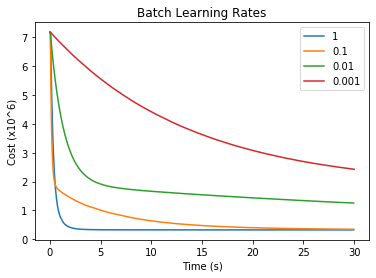

NOTE: Time limit for descent exceded.
NOTE: Time limit for descent exceded.
NOTE: Time limit for descent exceded.
NOTE: Time limit for descent exceded.


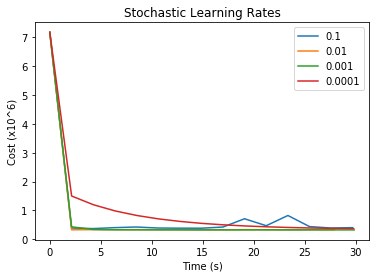

NOTE: Time limit for descent exceded.
NOTE: Time limit for descent exceded.
NOTE: Time limit for descent exceded.
NOTE: Time limit for descent exceded.


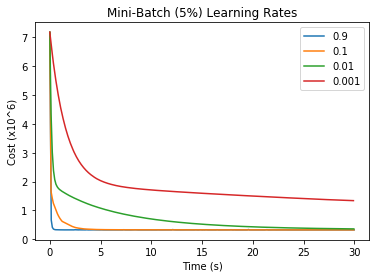

In [13]:
X,T,Y = X_1,T_1,Y_1
alpha_comparison(X,T,Y,'b', "Batch Learning Rates", [1, 0.1, 0.01, 0.001])
alpha_comparison(X,T,Y,'s', "Stochastic Learning Rates", [0.1, 0.01, 0.001, 0.0001])
alpha_comparison(X,T,Y,'m', "Mini-Batch (5%) Learning Rates", [0.9, 0.1, 0.01, 0.001])

Assim, percebemos que os melhores learning rates são:
- 1, para batch
- 0.01, para stochastic (pois 0.1 oscila muito)
- 0.9, para mini-batch

Assim, podemos comparar os 3 modelos com seus melhores learning rates, para definir o melhor.

NOTE: Time limit for descent exceded.
Batch GD
Score R2: 0.829
NOTE: Time limit for descent exceded.

Mini-Batch GD
Score R2: 0.829
NOTE: Time limit for descent exceded.

Stochastic GD
Score R2: 0.825


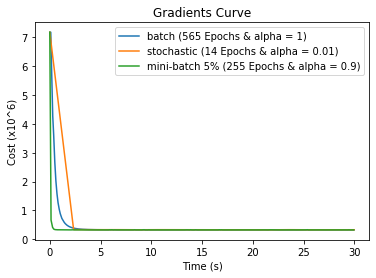

In [14]:
Tt = descent(X, T, Y, t_lim=30, e_lim=10000, rate=1)
batch = []
batch.append([cost(X, i, Y)/10**6 for i in epochs_info[0]])
batch.append(epochs_info[1][:])
print("Batch GD")
print("Score R2: %.3f" % score(X_val_1,Tt,Y_val_1))

Tt = descent(X, T, Y, t_lim=30, e_lim=10000, type='m', rate=0.9, mb_size=int(0.05*Y.shape[0]))
minib = []
minib.append([cost(X, i, Y)/10**6 for i in epochs_info[0]])
minib.append(epochs_info[1][:])
print("\nMini-Batch GD")
print("Score R2: %.3f" % score(X_val_1,Tt,Y_val_1))

Tt = descent(X, T, Y, t_lim=30, e_lim=10000, rate=0.01, type='s')
stoch = []
stoch.append([cost(X, i, Y)/10**6 for i in epochs_info[0]])
stoch.append(epochs_info[1][:])
print("\nStochastic GD")
print("Score R2: %.3f" % score(X_val_1,Tt,Y_val_1))
    
plt.plot(batch[1], batch[0], label='batch ('+str(len(batch[0])-1)+' Epochs & alpha = 1)')
plt.plot(stoch[1], stoch[0], label='stochastic ('+str(len(stoch[0])-1)+' Epochs & alpha = 0.01)')
plt.plot(minib[1], minib[0], label='mini-batch 5% ('+str(len(minib[0])-1)+' Epochs & alpha = 0.9)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Cost (x10^6)')
plt.title('Gradients Curve')
plt.show()

Com isso, sabemos que nosso melhor modelo é o mini-batch (5%), com learning rate 0.9. A partir deste ponto usaremos 0.1, pois ainda pode ficar instável com 0.9.

Realizando então últimos testes com ele, podemos colocar seu gráfico de função de custo por época, com seu score R2 final no conjunto de validação e RMSE.

Regressão Linear Implementada



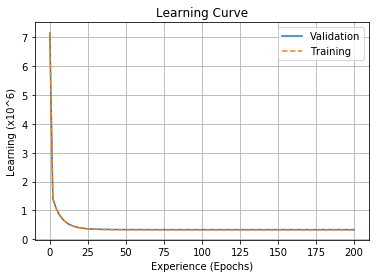

Score R2: 0.829
Variance Score: 0.829
RMSE: 815.233
Erro Mediano: 441.009


In [15]:
Tt = descent(X, T, Y, t_lim=30, e_lim=200, rate=0.1, type='m', mb_size=int(0.05*Y.shape[0]))

train = []
valid = []
E = epochs_info[0]
    
step = int(max(1, np.floor(len(E)/100)))
exp = range(0, len(E), step)

for i in exp:
    train.append(cost(X,E[i],Y)/10**6)
    valid.append(cost(X_val_1,E[i],Y_val_1)/10**6)

plt.plot(exp, valid, label='Validation')
plt.plot(exp, train, label='Training', ls='--')
plt.legend()
plt.xlabel('Experience (Epochs)')
plt.ylabel('Learning (x10^6)')
plt.title('Learning Curve')
plt.grid()

print("Regressão Linear Implementada\n")
plt.show()

pred = predict(X_val_1, Tt)

print("Score R2: %.3f" % score(X_val_1,Tt,Y_val_1))
print("Variance Score: %.3f" % explained_variance_score(Y_val_1, pred))
print("RMSE: %.3f" % np.sqrt(mean_squared_error(Y_val_1, pred)))
print("Erro Mediano: %.3f" % median_absolute_error(Y_val_1, pred))

Temos então como comparar esse resultado com o obtido pelo SGDRegressor da biblioteca SKLearn e pela equação normal.
A matriz resultante do modelo atual não é invertível, provavelmente por conter _features_ linearmente dependentes, então para a equação normal usaremos o segundo modelo.

In [16]:
Tn = normal_equation(X_2,Y_2)
pred = predict(X_val_2, Tn)
print("Normal Equation\n")
print("Score R2: %.3f" % score(X_val_2,Tn,Y_val_2))
print("Variance Score: %.3f" % explained_variance_score(Y_val_2, pred))
print("RMSE: %.3f" % np.sqrt(mean_squared_error(Y_val_2, pred)))
print("Erro Mediano: %.3f" % median_absolute_error(Y_val_2,pred))

Ys =np.ravel(Y)
clf = sk_regressor(X, Ys, rate=0.001)
pred = clf.predict(X_val_1).reshape(len(Y_val_1),1)
print("\nSKLEARN: Alpha = 0.001\n")
print("Score R2: %.3f" % clf.score(X_val_1,Y_val_1))
print("Variance Score: %.3f" % explained_variance_score(Y_val_1, pred))
print("RMSE: %.3f" % np.sqrt(mean_squared_error(Y_val_1, pred)))
print("Erro Mediano: %.3f" % median_absolute_error(Y_val_1,pred))

clf = sk_regressor(X, Ys, rate=0.01)
pred = clf.predict(X_val_1).reshape(len(Y_val_1),1)
print("\nSKLEARN: Alpha = 0.01\n")
print("Score R2: %.3f" % clf.score(X_val_1,Y_val_1))
print("Variance Score: %.3f" % explained_variance_score(Y_val_1, pred))
print("RMSE: %.3f" % np.sqrt(mean_squared_error(Y_val_1, pred)))
print("Erro Mediano: %.3f" % median_absolute_error(Y_val_1,pred))

Normal Equation

Score R2: -787278.344
Variance Score: -697695.537
RMSE: 1750758.881
Erro Mediano: 599292.230

SKLEARN: Alpha = 0.001

Score R2: 0.828
Variance Score: 0.829
RMSE: 816.471
Erro Mediano: 459.209

SKLEARN: Alpha = 0.01

Score R2: 0.801
Variance Score: 0.801
RMSE: 879.547
Erro Mediano: 592.764


Temos que o desempenho do modelo implementado para 30 segundos e do SGDRegressor são similares, tanto em termos de R2 Score quanto de RMSE ou Variance Score. O principal diferencial é o tempo gasto em cada um, sendo o da biblioteca bem mais rápido, possivelmente por utilizar incremento mínimo como critério de parada. Nosso modelo possui uma pequena vantagem.

Esse resultado é visto para learning rate menor. Se utilizarmos o mesmo learning rate, vemos que o resultado piora, sendo pior que o modelo implementado.

Percebe-se que o resultado da equação normal não foi bom, não representando em quase nada o conjunto.

Diversos testes foram feitos durante vários dias, e o seguinte conjunto, bem mais fraco, forneceu um resultado para a equação normal:

In [25]:
def prepare_dataset_norm(set_path):
    
    # Reading file to dataframe
    df = pd.read_csv(set_path)
    
    # Cleaning
    df = process_input_norm(df)
    
    Y = df['traffic_volume'].values
    Y = Y.reshape(len(Y),1)
    
    X = df.drop(axis=1, labels='traffic_volume')
    
    feat_norm = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'day', 'hour', 'year', 'month']
    feat_idx = [X.columns.get_loc(c) for c in feat_norm]
    
    return X.values,Y,feat_idx

def process_input_norm(data):
    ''' Remove and re-format input data.
        Receives pandas dataframe with all data.
        Returns processed data.
    '''
    # Removes 0 kelvin values, ridiculous amounts of rain and duplicate measurements for same time.
    data.drop(data[(data['temp'] == 0) | (data['rain_1h'] > 300)].index, inplace = True)
    data.drop_duplicates('date_time', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    # Get day, hour, month, year
    data['date_time'] = pd.to_datetime(data['date_time'])
    data['hour'] = data['date_time'].dt.hour
    data['day'] = data['date_time'].dt.day
    data['month'] = data['date_time'].dt.month
    data['year'] = data['date_time'].dt.year

    # Get weekdays
    data['weekday'] = data['date_time'].dt.weekday    
    data['weekday'] = np.where((data['weekday']) == 5 | (data['weekday'] == 6), 0, 1)
    
    data.drop(labels=['date_time','holiday'], axis=1, inplace=True)
    
    # Get peak, commercial and night times
    peak = list(range(15,18))
    comm = list(range(6, 19))
    night= list(range(0,5))
    data['peak'] = np.where((data['hour'] >= peak[0]) & (data['hour'] <= peak[-1]), 1, 0)
    data['commercial'] = np.where((data['hour'] >= comm[0]) & (data['hour'] <= comm[-1]), 1, 0)
    data['night'] = np.where((data['hour'] >= night[0]) & (data['hour'] <= night[-1]), 1, 0)
    
    data.drop(labels=['weather_description', 'weather_main'], axis=1, inplace=True)

    return data

In [29]:
X,Y,feat_list = prepare_dataset_norm('training.csv')
X_v, Y_v, _ = prepare_dataset_norm('validate.csv')
X = normalize_data(X, choice=1, features=feat_list)
X_v = normalize_data(X_v, choice=1, features=feat_list)
X,T,Y = numpy_and_bias(X,Y)
X_v,_,Y_v = numpy_and_bias(X_v,Y_v)

Tn = normal_equation(X,Y)
pred = predict(X_v, Tn)
print("Normal Equation\n")
print("Score R2: %.3f" % score(X_v,Tn,Y_v))
print("Variance Score: %.3f" % explained_variance_score(Y_v, pred))
print("RMSE: %.3f" % np.sqrt(mean_squared_error(Y_v, pred)))
print("Erro Mediano: %.3f" % median_absolute_error(Y_v,pred))

Ys =np.ravel(Y)
clf = sk_regressor(X, Ys, rate=0.001)
pred = clf.predict(X_v).reshape(len(Y_v),1)
print("\nSKLEARN: Alpha = 0.001\n")
print("Score R2: %.3f" % clf.score(X_v,Y_v))
print("Variance Score: %.3f" % explained_variance_score(Y_v, pred))
print("RMSE: %.3f" % np.sqrt(mean_squared_error(Y_v, pred)))
print("Erro Mediano: %.3f" % median_absolute_error(Y_v,pred))

T = descent(X, T, Y, t_lim=30, e_lim=200, rate=0.1, type='m', mb_size=int(0.05*Y.shape[0]))
pred = predict(X_v, T)
print("\nModelo Implementado\n")
print("Score R2: %.3f" % score(X_v,T,Y_v))
print("Variance Score: %.3f" % explained_variance_score(Y_v, pred))
print("RMSE: %.3f" % np.sqrt(mean_squared_error(Y_v, pred)))
print("Erro Mediano: %.3f" % median_absolute_error(Y_v, pred))

Normal Equation

Score R2: 0.744
Variance Score: 0.744
RMSE: 999.140
Erro Mediano: 503.503

SKLEARN: Alpha = 0.001

Score R2: 0.743
Variance Score: 0.743
RMSE: 1000.578
Erro Mediano: 505.702

Modelo Implementado

Score R2: 0.743
Variance Score: 0.743
RMSE: 1000.440
Erro Mediano: 502.887
